## Imports

In [1]:
import os
import json
import random
import torch
import torchaudio
from kan import KAN
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchaudio.transforms as T
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio
import random

import librosa
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Utils

In [3]:
def get_model_size(model):
    param_size = 0
    buffer_size = 0
    total_params = 0
    trainable_params = 0

    for param in model.parameters():
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
        param_size += param.numel() * param.element_size()  # size in bytes

    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()

    total_size_mb = (param_size + buffer_size) / (1024 ** 2)  # Convert bytes to MB

    print(f"Model size       : {total_size_mb:.4f} MB")
    print(f"Total parameters : {total_params:,}")
    print(f"Trainable params : {trainable_params:,}")

    return {
        "size_mb": total_size_mb,
        "total_params": total_params,
        "trainable_params": trainable_params
    }



In [4]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_mono_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = 1, waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [5]:
from datetime import datetime
import time

class DiPCoSeparationDataset(Dataset):
    def __init__(self, root_dir='./data/Dipco/', session_ids=['S02', 'S04'], version='dev', 
                segment_length=4, sr=16000, max_pairs=10000, seed=0):
        
        self.sr = sr
        self.segment_samples = int(sr * segment_length)
        
        self.session_dict:dict[list] = {}
        self.pairs = []
        self.session_audio:dict[tuple[str, str],torch.Tensor] = {}
        

        for session_id in session_ids:
            trans_path = os.path.join(root_dir, 'transcriptions', version, f'{session_id}.json')
            print('Processing: ', trans_path)
            with open(trans_path, 'r') as f:
                session_trans = json.load(f)

            for utt in tqdm(session_trans):
                curr_speaker_id = utt['speaker_id']
                curr_valid_times = self.session_dict.get((session_id, curr_speaker_id), [])
                curr_start_time = self._time_str_to_sample(utt['start_time'], sr)
                curr_end_time = self._time_str_to_sample(utt['end_time'], sr)
                
                curr_valid_times.extend([(start, start + segment_length * sr) for start in range(curr_start_time, curr_end_time, self.segment_samples)])
                self.session_dict[(session_id, curr_speaker_id)] = curr_valid_times


            for speaker_1 in list(self.session_dict.keys())[:-1]:
                if speaker_1[0] != session_id:
                    continue
                speaker_1_times = self.session_dict[speaker_1]
                for speaker_2 in list(self.session_dict)[1:]:
                    if speaker_2[0] != session_id:
                        continue
                    speaker_2_times = self.session_dict[speaker_2]
                    for time1 in speaker_1_times:
                        for time2 in speaker_2_times:
                            self.pairs.append((speaker_1, time1, speaker_2, time2))
                            
            random.seed(seed)  
            random.shuffle(self.pairs)
            self.pairs = self.pairs[:max_pairs]

        for (key_session_id, key_speaker_id), times in self.session_dict.items():
            print((key_session_id, key_speaker_id), len(times), times)
            audio_path = os.path.join(root_dir, 'audio', version,
                                    f"{key_session_id}_{key_speaker_id}.wav")
            self.session_audio[(key_session_id, key_speaker_id)] = self._load_full_audio(audio_path)

            print((key_session_id, key_speaker_id),'audio length:',len(self.session_audio[(key_session_id, key_speaker_id)]))


    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        (speaker_1, time1, speaker_2, time2) = self.pairs[idx]
        audio1 = self.session_audio[speaker_1]
        audio2 = self.session_audio[speaker_2]
        if time1[1] > audio1.size(0):
            time1 = (audio1.size(0) - self.segment_samples, audio1.size(0))
        if time2[1] > audio2.size(0):
            time2 = (audio2.size(0) - self.segment_samples, audio2.size(0))
        clean1 = audio1[time1[0]:time1[1]]
        clean2 = audio2[time2[0]:time2[1]]

        mixed = (clean1 + clean2).clamp(-1, 1)

        clean1 = clean1
        clean2 = clean2
        mixed = mixed.unsqueeze(0)

        return mixed, torch.stack([clean1, clean2])

    def _time_str_to_sample(self, t_dict, sr):
        t_str = t_dict[list(t_dict.keys())[0]]
        t = datetime.strptime(t_str, "%H:%M:%S.%f")
        return int(sr * (t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1_000_000))
    
    def _load_full_audio(self, path):
        waveform, orig_sr = torchaudio.load(path)
        if orig_sr != self.sr:
            resampler = torchaudio.transforms.Resample(orig_sr, self.sr)
            waveform = resampler(waveform)
        waveform = torch.mean(waveform, dim=0)  # Convert to mono
        return waveform

In [6]:
train_dataset = DiPCoSeparationDataset(
    root_dir='./data/Dipco/',
    session_ids=['S02', 'S04'],#, 'S04', 'S05', 'S09', 'S10'],
    segment_length=4,
    sr=8000,
    max_pairs=1_000_000,
)
len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
len(train_dataset.pairs), train_dataset.pairs[0], len(train_loader)

Processing:  ./data/Dipco/transcriptions\dev\S02.json


  0%|          | 0/448 [00:00<?, ?it/s]

Processing:  ./data/Dipco/transcriptions\dev\S04.json


  0%|          | 0/1284 [00:00<?, ?it/s]

('S02', 'P05') 200 [(19680, 51680), (66800, 98800), (639360, 671360), (732800, 764800), (762320, 794320), (784240, 816240), (864560, 896560), (880720, 912720), (912720, 944720), (1062320, 1094320), (1105280, 1137280), (1147840, 1179840), (1247280, 1279280), (1272080, 1304080), (1349200, 1381200), (1443200, 1475200), (1471680, 1503680), (1503600, 1535600), (1541520, 1573520), (1593680, 1625680), (1896960, 1928960), (2023120, 2055120), (2106400, 2138400), (2138400, 2170400), (2165440, 2197440), (2172000, 2204000), (2212320, 2244320), (2285760, 2317760), (2317760, 2349760), (2329120, 2361120), (2356160, 2388160), (2391600, 2423600), (2417760, 2449760), (2575760, 2607760), (2607760, 2639760), (2619840, 2651840), (2648320, 2680320), (2680320, 2712320), (2712320, 2744320), (2741520, 2773520), (2773520, 2805520), (2805520, 2837520), (2837520, 2869520), (2865840, 2897840), (2882240, 2914240), (2912640, 2944640), (2945680, 2977680), (2957840, 2989840), (2989840, 3021840), (3021840, 3053840), (3

(1000000,
 (('S04', 'P15'), (10095920, 10127920), ('S04', 'P14'), (21664960, 21696960)),
 62500)

In [7]:
test_dataset = DiPCoSeparationDataset(
    root_dir='./data/Dipco/',
    version='eval',
    session_ids=['S01', 'S03'],
    segment_length=4,
    sr=8000,
    max_pairs=len(train_dataset.pairs) // 10,
)
len(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
len(test_dataset.pairs), test_dataset.pairs[0], len(test_loader)

Processing:  ./data/Dipco/transcriptions\eval\S01.json


  0%|          | 0/903 [00:00<?, ?it/s]

Processing:  ./data/Dipco/transcriptions\eval\S03.json


  0%|          | 0/1127 [00:00<?, ?it/s]

('S01', 'P01') 357 [(11600, 43600), (70240, 102240), (90720, 122720), (124960, 156960), (147280, 179280), (445440, 477440), (625200, 657200), (658240, 690240), (671600, 703600), (703600, 735600), (727120, 759120), (737440, 769440), (763200, 795200), (803280, 835280), (870560, 902560), (907280, 939280), (971280, 1003280), (1003280, 1035280), (1063680, 1095680), (1232880, 1264880), (1253760, 1285760), (1377280, 1409280), (1389360, 1421360), (1409760, 1441760), (1441760, 1473760), (1450960, 1482960), (1471760, 1503760), (1484960, 1516960), (1516960, 1548960), (1531120, 1563120), (1544480, 1576480), (1574160, 1606160), (1594240, 1626240), (1626240, 1658240), (1632880, 1664880), (1647040, 1679040), (1679040, 1711040), (1697920, 1729920), (1729920, 1761920), (1735600, 1767600), (1771120, 1803120), (1827360, 1859360), (1859360, 1891360), (1881280, 1913280), (1913280, 1945280), (1945280, 1977280), (2028560, 2060560), (2041600, 2073600), (2073600, 2105600), (2081679, 2113679), (2118320, 2150320

(100000,
 (('S03', 'P10'), (20582640, 20614640), ('S03', 'P11'), (20458160, 20490160)),
 6250)

1001 torch.Size([16, 1, 32000]) torch.Size([16, 2, 32000])
1001 torch.Size([16, 1, 32000]) torch.Size([16, 2, 32000])
torch.Size([16, 1, 32000]) torch.Size([16, 2, 32000])


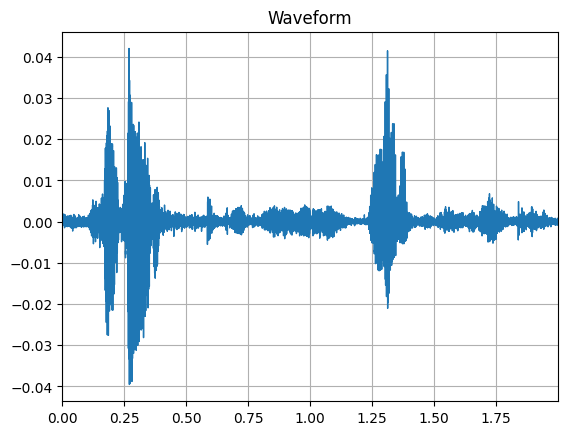

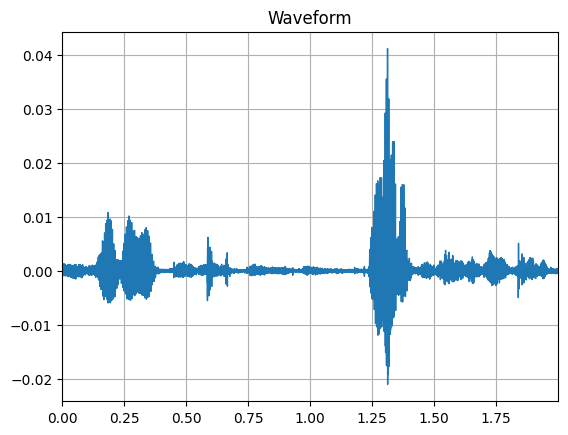

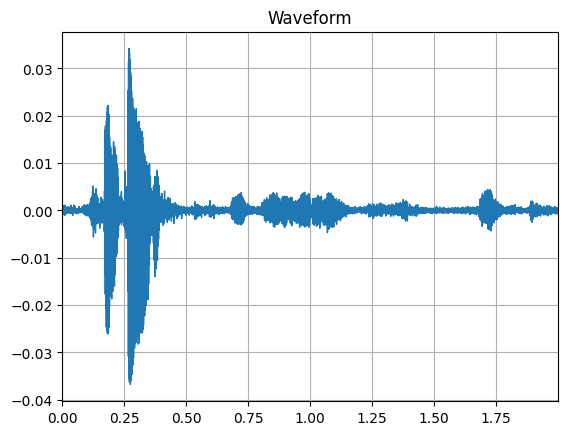

In [8]:
for idx, (mixed, clean) in enumerate(train_loader):
    print(idx, mixed.shape, clean.shape, end='\r')
    if idx > 1000:
        print()
        break
for idx, (mixed, clean) in enumerate(test_loader):
    print(idx, mixed.shape, clean.shape, end='\r')
    if idx > 1000:
        print()
        break

for mixed, clean in train_loader:
    print(mixed.shape, clean.shape)
    plot_mono_waveform(mixed[0][0], sr=16000)
    plot_mono_waveform(clean[0][0], sr=16000)
    plot_mono_waveform(clean[0][1], sr=16000)
    break



## Training

In [9]:
# class PermutationInvariantSISNRLoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.eps = 1e-8

#     def _si_snr(self, estimates, targets):
#         # estimates: [B, T]
#         # targets: [B, T]
#         estimates = estimates - estimates.mean(dim=-1, keepdim=True)
#         targets = targets - targets.mean(dim=-1, keepdim=True)

#         # Compute SI-SNR
#         s_target = (torch.sum(estimates * targets, dim=-1, keepdim=True) * targets) \
#                    / (torch.norm(targets, p=2, dim=-1, keepdim=True)**2 + self.eps)
        
#         e_noise = estimates - s_target
#         return 10 * torch.log10(
#             (torch.norm(s_target, p=2, dim=-1)**2 + self.eps) / 
#             (torch.norm(e_noise, p=2, dim=-1)**2 + self.eps)
#         )

#     def forward(self, outputs, targets):
#         """
#         Args:
#             outputs: [B, 2, T] separated waveforms
#             targets: [B, 2, T] original clean waveforms
#         Returns:
#             loss: scalar
#         """
#         # Compute all permutations
#         loss_0 = self._si_snr(outputs[:,0], targets[:,0]) + \
#                  self._si_snr(outputs[:,1], targets[:,1])
        
#         loss_1 = self._si_snr(outputs[:,0], targets[:,1]) + \
#                  self._si_snr(outputs[:,1], targets[:,0])

#         # Return negative of best permutation
#         return -torch.mean(torch.min(loss_0, loss_1))


In [10]:
# import torch
# import torch.nn as nn
# import itertools

# class SI_SNRLoss_2(nn.Module):
#     """
#     Scale-Invariant Signal-to-Noise Ratio Loss (SI-SNR) with 
#     Permutation Invariant Training (PIT) for multiple sources
#     """
#     def __init__(self, eps=1e-8):
#         super(SI_SNRLoss_2, self).__init__()
#         self.eps = eps
        
#     def forward(self, estimated, target):
#         """
#         Args:
#             estimated: Estimated sources with shape [batch_size, num_sources, time_steps]
#             target: Target sources with shape [batch_size, num_sources, time_steps]
            
#         Returns:
#             loss: Negative SI-SNR loss with the best permutation
#         """
#         batch_size, num_sources, _ = estimated.shape
        
#         # If only one source, no need for PIT
#         if num_sources == 1:
#             return self._calculate_si_snr(estimated.squeeze(1), target.squeeze(1))
        
#         # For multiple sources, use PIT
#         return self._calculate_pit_loss(estimated, target)
    
#     def _calculate_si_snr(self, estimated, target):
#         """Calculate SI-SNR between estimated and target sources"""
#         # Zero-mean normalization
#         estimated = estimated - torch.mean(estimated, dim=1, keepdim=True)
#         target = target - torch.mean(target, dim=1, keepdim=True)
        
#         # s_target calculation
#         dot_product = torch.sum(estimated * target, dim=1, keepdim=True)
#         target_energy = torch.sum(target ** 2, dim=1, keepdim=True) + self.eps
#         scaling = dot_product / target_energy
#         s_target = scaling * target
        
#         # Error calculation
#         e_noise = estimated - s_target
        
#         # SI-SNR calculation
#         s_target_energy = torch.sum(s_target ** 2, dim=1)
#         e_noise_energy = torch.sum(e_noise ** 2, dim=1) + self.eps
#         si_snr = 10 * torch.log10(s_target_energy / e_noise_energy)
        
#         return -torch.mean(si_snr)
    
#     def _calculate_pit_loss(self, estimated, target):
#         """Calculate PIT loss by finding the best permutation"""
#         batch_size, num_sources, time_steps = estimated.shape
        
#         # Compute SI-SNR for all possible pairs
#         si_snr_matrix = torch.zeros(batch_size, num_sources, num_sources).to(estimated.device)
        
#         for b in range(batch_size):
#             for i in range(num_sources):
#                 for j in range(num_sources):
#                     # Zero-mean normalization
#                     est_normalized = estimated[b, i] - torch.mean(estimated[b, i])
#                     tgt_normalized = target[b, j] - torch.mean(target[b, j])
                    
#                     # s_target calculation
#                     dot = torch.sum(est_normalized * tgt_normalized)
#                     tgt_energy = torch.sum(tgt_normalized ** 2) + self.eps
#                     scale = dot / tgt_energy
#                     s_target = scale * tgt_normalized
                    
#                     # Error calculation
#                     e_noise = est_normalized - s_target
                    
#                     # SI-SNR calculation
#                     s_energy = torch.sum(s_target ** 2)
#                     e_energy = torch.sum(e_noise ** 2) + self.eps
#                     si_snr = 10 * torch.log10(s_energy / e_energy)
                    
#                     si_snr_matrix[b, i, j] = si_snr
        
#         # Find the best permutation for each sample in the batch
#         total_loss = 0
#         for b in range(batch_size):
#             perms = list(itertools.permutations(range(num_sources)))
#             max_si_snr = -float('inf')
            
#             for perm in perms:
#                 # Calculate sum of SI-SNRs for this permutation
#                 si_snr_sum = sum(si_snr_matrix[b, i, perm[i]] for i in range(num_sources))
                
#                 if si_snr_sum > max_si_snr:
#                     max_si_snr = si_snr_sum
            
#             # Add the best SI-SNR (divided by num_sources to get the average)
#             total_loss -= max_si_snr / num_sources
        
#         return total_loss / batch_size


In [11]:
import torch
import torch.nn as nn
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio

class SI_SNRLoss(nn.Module):
    """
    SI-SNR loss for two-source separation with Permutation Invariant Training (PIT)
    """
    def __init__(self, device):
        super(SI_SNRLoss, self).__init__()
        self.si_snr_metric = ScaleInvariantSignalNoiseRatio().to(device)
        
    def forward(self, estimated, target):
        """
        Calculate SI-SNR loss with PIT for two sources
        
        Args:
            estimated: Estimated source signals with shape [batch_size, 2, time_steps]
            target: Target source signals with shape [batch_size, 2, time_steps]
            
        Returns:
            loss: Negative SI-SNR loss (to minimize)
        """
        batch_size = estimated.shape[0]
        total_loss = 0.0
        
        # For each sample in the batch
        for b in range(batch_size):
            # Calculate SI-SNR for original permutation (0,1)
            si_snr_1 = self.si_snr_metric(estimated[b, 0], target[b, 0])
            si_snr_2 = self.si_snr_metric(estimated[b, 1], target[b, 1])
            perm1_score = si_snr_1 + si_snr_2
            
            # Calculate SI-SNR for alternative permutation (1,0)
            si_snr_3 = self.si_snr_metric(estimated[b, 0], target[b, 1])
            si_snr_4 = self.si_snr_metric(estimated[b, 1], target[b, 0])
            perm2_score = si_snr_3 + si_snr_4
            
            # Choose the permutation with the higher score
            best_score = torch.maximum(perm1_score, perm2_score)
            
            # Add to the batch total (negative because we want to minimize loss)
            total_loss -= best_score
        
        # Return average loss across the batch
        return total_loss / batch_size


In [12]:
import csv

model_dir = './models'
os.makedirs(model_dir, exist_ok=True)
os.makedirs('./plots', exist_ok=True)

# Create a log file for tracking losses
log_file_path = os.path.join(model_dir, 'training_log.csv')
with open(log_file_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['timestamp', 'epoch', 'iteration', 'train_loss', 'val_loss', 'checkpoint'])

def log_loss(epoch, iteration, train_loss, val_loss=None, checkpoint=None):
    with open(log_file_path, 'a', newline='') as f:
        writer = csv.writer(f)
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        writer.writerow([timestamp, epoch+1, iteration + 1, train_loss, val_loss if val_loss is not None else '', 
                        checkpoint if checkpoint is not None else ''])

In [13]:
from torchaudio.models import ConvTasNet

model = ConvTasNet(num_sources=2, enc_kernel_size=16, enc_num_feats=16,msk_kernel_size=3, msk_num_feats=8, msk_num_hidden_feats=16, msk_num_layers=3, msk_num_stacks=3).to(device)
get_model_size(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion  = SI_SNRLoss(device)

Model size       : 0.0219 MB
Total parameters : 5,747
Trainable params : 5,747


torch.Size([16, 1, 32000]) torch.Size([16, 2, 32000]) tensor(0.0004)
torch.Size([16, 2, 32000])
tensor(40.8644, device='cuda:0', grad_fn=<DivBackward0>)


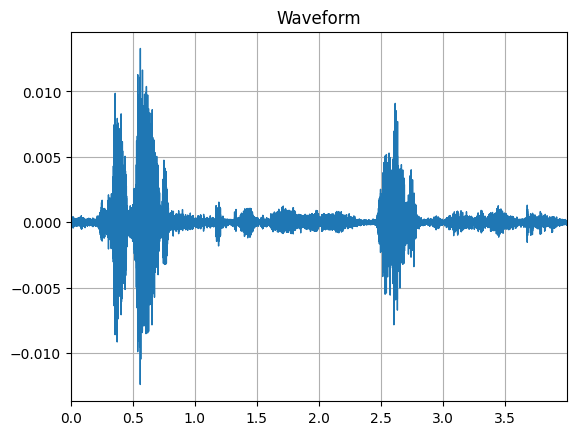

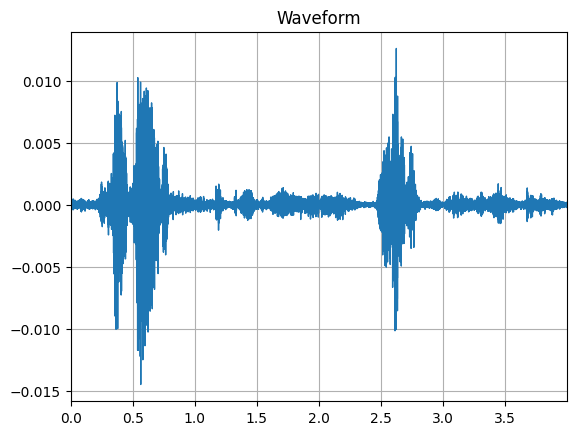

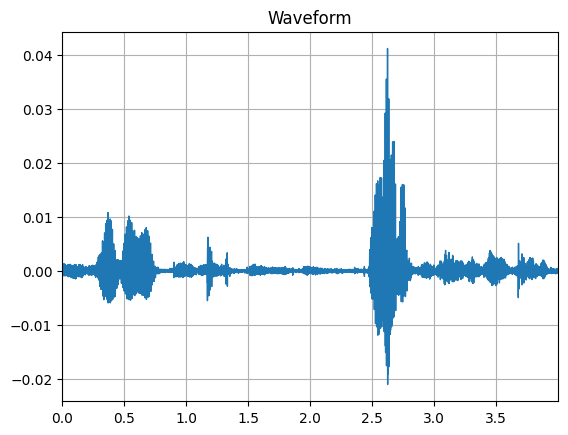

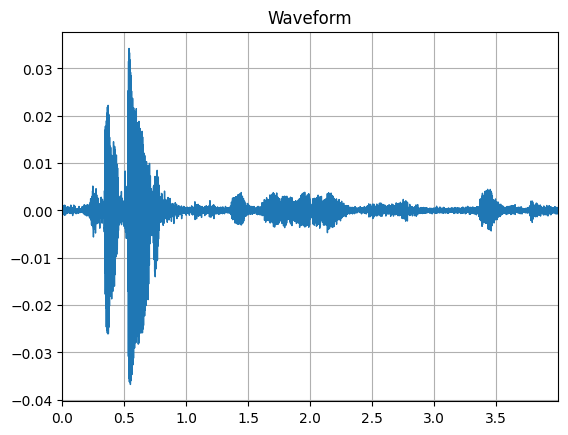

In [14]:
for mixed, clean in train_loader:
    print(mixed.shape, clean.shape, mixed[0][0][0])
    mixed = mixed.to(device)
    clean = clean.to(device)
    model.eval()
    outputs = model(mixed)
    print(outputs.shape)
    loss = criterion(outputs, clean)
    print(loss)
    break

outputs.shape, outputs[0][0].shape
plot_mono_waveform((outputs[0][0].cpu().detach()[:]), sr=8000)
plot_mono_waveform((outputs[0][1].cpu().detach()[:]), sr=8000)
plot_mono_waveform(clean[0][0].cpu().detach(), sr=8000)
plot_mono_waveform(clean[0][1].cpu().detach(), sr=8000)

In [15]:


prev_val_loss = float('inf')
consecutive_val_increases = 0
patience = 3

for epoch in range(2):
    epoch_loss = 0
    for s_idx, (mixed, clean) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch + 1}', position=epoch, total=len(train_loader)):
        model.train()
        # print(mixed.shape, clean.shape)
        mixed = mixed.to(device)
        clean = clean.to(device)
        optimizer.zero_grad()
        outputs = model(mixed)
        # print(outputs.shape)
        loss = criterion(outputs, clean)
        # print(loss.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


        frequency = 1000
        if (s_idx) % frequency == 0:
            full_val_loss = 0
            for test_idx, (val_mixed, val_clean) in enumerate(test_loader):
                model.eval()
                with torch.no_grad():
                    print('Testing', test_idx ,'/', frequency * len(test_loader) / len(train_loader), end='\r')
                    val_mixed = val_mixed.to(device)
                    val_clean = val_clean.to(device)
                    val_outputs = model(val_mixed)
                    val_loss = criterion(val_outputs, val_clean)
                    full_val_loss += val_loss.item()
                    if test_idx >= frequency * len(test_loader) / len(train_loader):
                        break
                
            log_loss(epoch, s_idx, epoch_loss / (s_idx + 1), full_val_loss / (frequency * len(test_loader) / len(train_loader)))
            checkpoint_path = os.path.join(model_dir,f'simple_convtasnet_epoch{epoch+1}_{s_idx+1}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved model checkpoint to {checkpoint_path}, Loss: {epoch_loss/(s_idx+1)}, Val_Loss: {full_val_loss/(frequency * len(test_loader) / len(train_loader))}")

            if full_val_loss > prev_val_loss:
                consecutive_val_increases +=1
                if consecutive_val_increases >= patience:
                    print('Early Stopping, val loss went up')
                    break
            else:
                consecutive_val_increases = 0
            prev_val_loss = full_val_loss



    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")
    checkpoint_path = checkpoint_path = os.path.join(model_dir,f'simple_convtasnet_epoch{epoch+1}_final.pth')
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved model checkpoint to {checkpoint_path}")
    full_val_loss = 0
    for test_idx, (val_mixed, val_clean) in enumerate(test_loader):
        model.eval()
        print('Testing', test_idx ,'/', len(test_loader), end='\r')
        val_mixed = val_mixed.to(device)
        val_clean = val_clean.to(device)
        val_outputs = model(val_mixed)
        val_loss = criterion(val_outputs, val_clean)
        full_val_loss += val_loss.item()
    print(f" Val_Loss: {full_val_loss/ len(test_loader)}")
    log_loss(epoch, s_idx, epoch_loss / (s_idx + 1), full_val_loss / len(test_loader), checkpoint='Final')

Epoch 1:   0%|          | 0/62500 [00:00<?, ?it/s]

Saved model checkpoint to ./models\simple_convtasnet_epoch1_1.pth, Loss: 40.86437225341797, Val_Loss: 37.5043371963501
Saved model checkpoint to ./models\simple_convtasnet_epoch1_1001.pth, Loss: 11.01459463623973, Val_Loss: 3.079085868000984
Saved model checkpoint to ./models\simple_convtasnet_epoch1_2001.pth, Loss: 6.027389492361114, Val_Loss: 0.18035323195159436
Saved model checkpoint to ./models\simple_convtasnet_epoch1_3001.pth, Loss: 3.6871316089694877, Val_Loss: -0.8876716504245996
Saved model checkpoint to ./models\simple_convtasnet_epoch1_4001.pth, Loss: 2.2495063086545666, Val_Loss: -1.5056592305377126
Saved model checkpoint to ./models\simple_convtasnet_epoch1_5001.pth, Loss: 1.2412475457273824, Val_Loss: -1.8510969758033753
Saved model checkpoint to ./models\simple_convtasnet_epoch1_6001.pth, Loss: 0.5034396340836189, Val_Loss: -1.9388930356502534
Saved model checkpoint to ./models\simple_convtasnet_epoch1_7001.pth, Loss: -0.0884594225141512, Val_Loss: -2.151377141773701
Sav

KeyboardInterrupt: 

In [17]:
criterion(outputs, clean)

tensor(-6.3135, device='cuda:0', grad_fn=<DivBackward0>)

Epoch 1:   0%|          | 0/62500 [00:00<?, ?it/s]

torch.Size([16, 1, 32000]) torch.Size([16, 2, 32000]) tensor(0.0004)
torch.Size([16, 2, 32000])
tensor(-6.3561, device='cuda:0', grad_fn=<DivBackward0>)


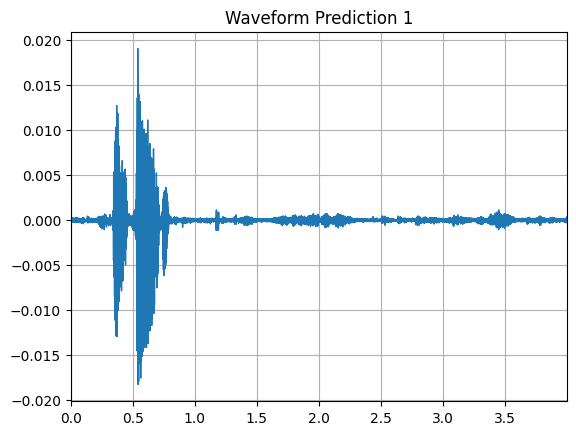

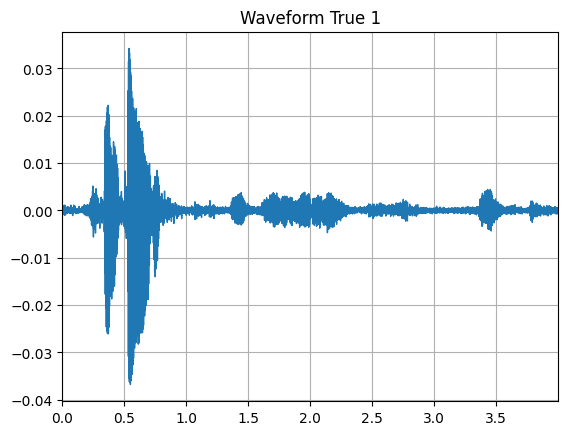

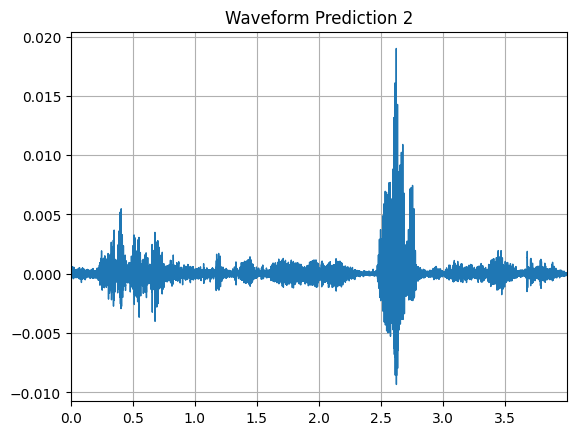

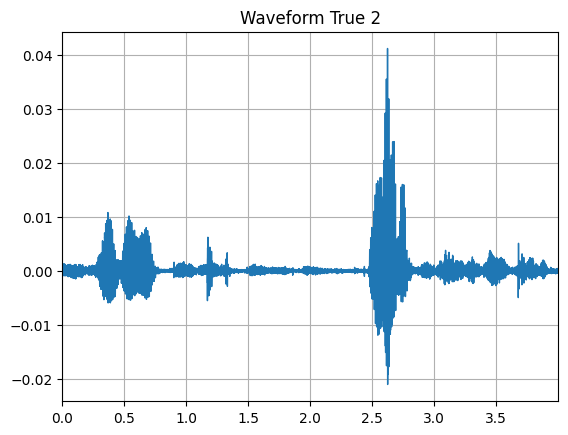

In [20]:
for mixed, clean in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        print(mixed.shape, clean.shape, mixed[0][0][0])
        mixed = mixed.to(device)
        clean = clean.to(device)
        model.eval()
        outputs = model(mixed)
        print(outputs.shape)
        loss = criterion(outputs, clean)
        print(loss)
        break

outputs.shape, outputs[0][0].shape
plot_mono_waveform((outputs[0][0].cpu().detach()[:]), sr=8000, title='Waveform Prediction 1')
plot_mono_waveform(clean[0][1].cpu().detach(), sr=8000, title='Waveform True 1')
plot_mono_waveform((outputs[0][1].cpu().detach()[:]), sr=8000, title='Waveform Prediction 2')
plot_mono_waveform(clean[0][0].cpu().detach(), sr=8000, title='Waveform True 2')